In [168]:
import torch
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import numpy as np

From Github

In [ ]:
class MirrorDescent(Optimizer):

    def __init__(self, params, lr, mirror_map):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        
        defaults = dict(lr=lr, mirror_map=mirror_map)
        super(MirrorDescent, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            mirror_map = group['mirror_map']

            for p in group['params']:
                if p.grad is not None:
                    grad = p.grad.data
                    p.data = mirror_map(p.data - lr * grad)
        return loss


In [178]:
# Mirror map to pochodna funkcji lustrzanej
# Funkcja równoważna z Gradient Descent
def mirror_map(x):
    return x

def rosenbrock(x):
    return 100.0 * (x[1] - x[0]**2)**2 + (1.0 - x[0])**2

def grad_rosenbrock(x):
    dx = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    dy = 200 * (x[1] - x[0]**2)
    return torch.tensor([dx, dy], dtype=torch.float32)

# Parametru do optymalizacji
x = torch.nn.Parameter(torch.rand(2, dtype=torch.float32))

# Tworzymy optymalizator Mirror Descent z mirror map 
optimizer = MirrorDescent([x], lr=1e-3, mirror_map=mirror_map)

trajectory = [x.detach().clone()]
tolerance = 1e-3

for i in range(50000):
    optimizer.zero_grad()

    loss = rosenbrock(x)
    loss.backward()
    optimizer.step()
    
    trajectory.append(x.detach().clone())
    
    grad_norm = torch.norm(x.grad.detach())
    if grad_norm < tolerance:
        print(f"Early stopping at step {i}, final point: {x.detach()}, grad norm: {grad_norm:}")
        break

trajectory = torch.stack(trajectory).numpy()

Early stopping at step 12088, final point: tensor([0.9989, 0.9978]), grad norm: 0.0009996936423704028


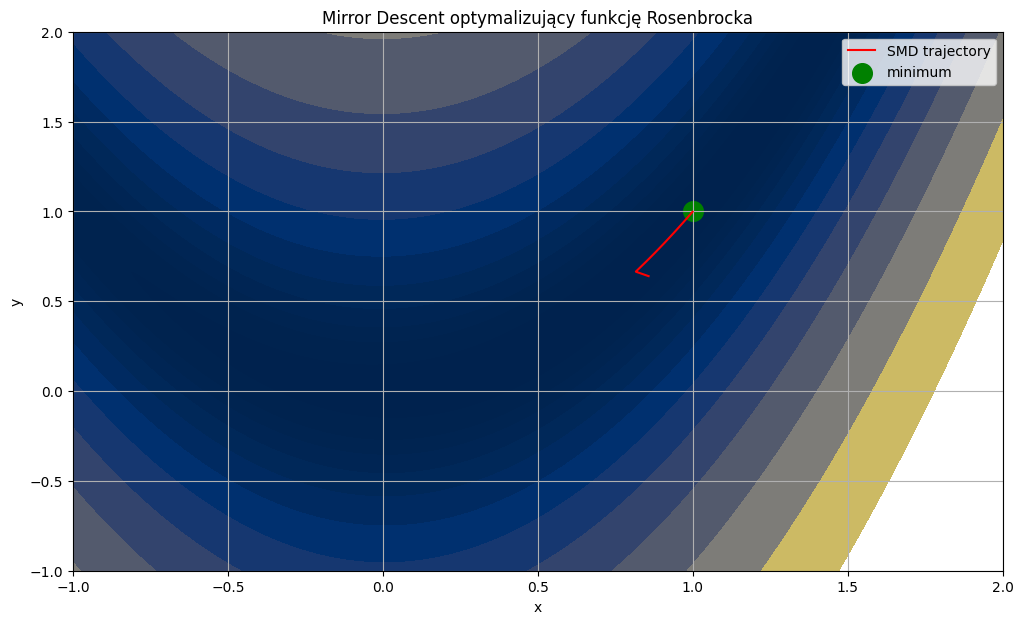

In [182]:
X, Y = np.meshgrid(np.linspace(-1, 2, 400), np.linspace(-1, 2, 400))
Z = 100.0 * (Y - X**2)**2 + (1.0 - X)**2

plt.figure(figsize=(12, 7))
plt.contourf(X, Y, Z, levels=np.logspace(-3, 3, 30), cmap="cividis")
plt.plot(trajectory[:, 0], trajectory[:, 1], color="red", label="SMD trajectory")
plt.scatter([1], [1], color='green', label='minimum', s=200)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Mirror Descent optymalizujący funkcję Rosenbrocka")
plt.grid(True)
plt.show()